In [0]:
from google.colab import files
def getLocalFiles():
    _files = files.upload()
    if len(_files) >0:
       for k,v in _files.items():
         open(k,'wb').write(v)
getLocalFiles()

In [0]:
import numpy as np
np.random.seed(42)
import tensorflow as tf
tf.set_random_seed(42)
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation
from keras.layers import LSTM, Dropout
from keras.layers import TimeDistributed
from keras.layers.core import Dense, Activation, Dropout, RepeatVector
from keras.optimizers import RMSprop
import matplotlib.pyplot as plt
import pickle
import sys
import heapq
import seaborn as sns
from pylab import rcParams

In [0]:
%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 12, 5

In [0]:
path = 'cdata.txt'
text = open(path).read()
# print(text)

In [0]:
chars = sorted(list(set(text)))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

print(f'unique chars: {len(chars)}')
# print((chars))

unique chars: 55


In [0]:
SEQUENCE_LENGTH = 40
step = 3
sentences = []
next_chars = []
for i in range(0, len(text) - SEQUENCE_LENGTH, step):
    sentences.append(text[i: i + SEQUENCE_LENGTH])
    next_chars.append(text[i + SEQUENCE_LENGTH])
print(f'num training examples: {len(sentences)}')

num training examples: 4208


In [0]:
X = np.zeros((len(sentences), SEQUENCE_LENGTH, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        X[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

In [0]:
sentences[100]

'ना  द्वारा बनाया गया  कहते हैं  जीता  दे'

In [0]:
next_chars[100]

'ख'

In [0]:
model = Sequential()
model.add(LSTM(128, input_shape=(SEQUENCE_LENGTH, len(chars))))
model.add(Dense(len(chars)))
model.add(Activation('softmax'))

In [0]:
optimizer = RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history = model.fit(X, y, validation_split=0.05, batch_size=128, epochs=20, shuffle=True).history

Train on 3997 samples, validate on 211 samples
Epoch 1/20
3997/3997 [==============================] - 4s 1ms/step - loss: 3.1233 - acc: 0.2677 - val_loss: 2.8065 - val_acc: 0.3033
Epoch 2/20
3997/3997 [==============================] - 3s 718us/step - loss: 2.4093 - acc: 0.3890 - val_loss: 2.1880 - val_acc: 0.4313
Epoch 3/20
3997/3997 [==============================] - 3s 708us/step - loss: 2.0567 - acc: 0.4516 - val_loss: 2.0742 - val_acc: 0.4645
Epoch 4/20
3997/3997 [==============================] - 3s 713us/step - loss: 1.8697 - acc: 0.4829 - val_loss: 1.8967 - val_acc: 0.5213
Epoch 5/20
3997/3997 [==============================] - 3s 721us/step - loss: 1.7134 - acc: 0.5131 - val_loss: 1.8948 - val_acc: 0.5118
Epoch 6/20
3997/3997 [==============================] - 3s 723us/step - loss: 1.5913 - acc: 0.5339 - val_loss: 1.8438 - val_acc: 0.5498
Epoch 7/20
3997/3997 [==============================] - 3s 709us/step - loss: 1.4748 - acc: 0.5632 - val_loss: 1.9798 - val_acc: 0.4550
Epo

In [0]:
model.save('keras_model.h5')
pickle.dump(history, open("history.p", "wb"))

In [0]:
model = load_model('keras_model.h5')
history = pickle.load(open("history.p", "rb"))

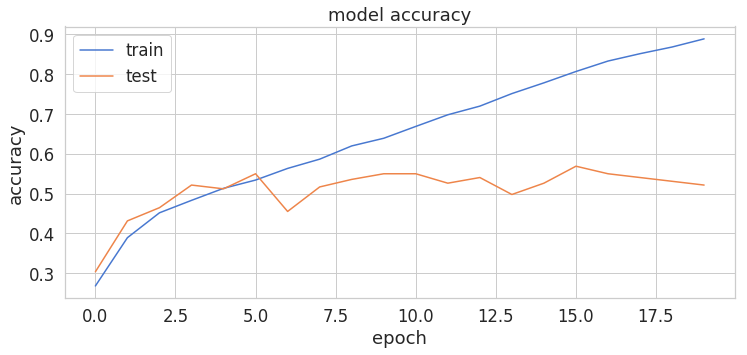

In [0]:
plt.plot(history['acc'])
plt.plot(history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left');

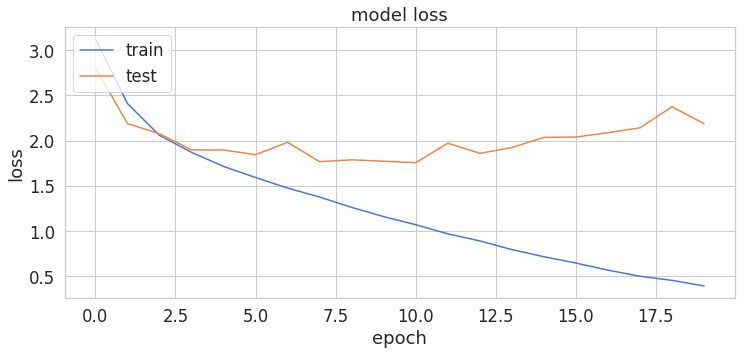

In [0]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left');

In [0]:
def sample(preds, top_n=3):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds)
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    
    return heapq.nlargest(top_n, range(len(preds)), preds.take)

In [0]:
def prepare_input(text):
    x = np.zeros((1, SEQUENCE_LENGTH, len(chars)))
    for t, char in enumerate(text):
        x[0, t, char_indices[char]] = 1.
        
    return x

In [0]:
def predict_completion(text):
    original_text = text
    generated = text
    completion = ''
    while True:
        x = prepare_input(text)
        preds = model.predict(x, verbose=0)[0]
        next_index = sample(preds, top_n=1)[0]
        next_char = indices_char[next_index]
        text = text[1:] + next_char
        completion += next_char
        
        if len(original_text + completion) + 2 > len(original_text) and next_char == ' ':
            return completion

In [0]:
def predict_completions(text, n):
    print(text)
    x = prepare_input(text)
    preds = model.predict(x, verbose=0)[0]
    next_indices = sample(preds, n)
    return [indices_char[idx] + predict_completion(text[1:] + indices_char[idx]) for idx in next_indices]

In [0]:
quotes = "बनाते क"
# "जीता  देखा  बने  प्रकाशित  नामक  हुई  का निर्माण  शामिल हैं ","जमा  जैसे  दायर किया  देखता है "
print(quotes[0:7])

बनाते क


In [0]:
# for q in quotes:
#   seq = q[0:5]
#   print(seq)
# print( predict_completions(seq, 5))
# # print()
seq = quotes[0:5]
# print(seq)
print( predict_completions(seq, 20))

बनाते
['  ', 'क ', 'आ ', 'व ', 'भ ', 'त ', 'ं ', 'ो ', 'ि ', 'स ', 'च ', 'ह ', 'द ', 'थ ', '् ', 'े ', 'श ', 'न ', 'य ', 'ष ']
